VGG19 model on the Melanoma Cancer Image Dataset

In [6]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Recall
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG19
from tensorflow.keras.metrics import Recall

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # no warnings

In [4]:
#Uploading the dataset
from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [5]:
import zipfile
import os

os.makedirs('data', exist_ok=True)

with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [8]:
train_dir = 'data/train'
test_dir = 'data/test'

In [9]:
# check total images in every map
train_benign_count = len(os.listdir(os.path.join(train_dir, 'Benign')))
train_malignant_count = len(os.listdir(os.path.join(train_dir, 'Malignant')))
test_benign_count = len(os.listdir(os.path.join(test_dir, 'Benign')))
test_malignant_count = len(os.listdir(os.path.join(test_dir, 'Malignant')))

print(f"Train Benign samples: {train_benign_count}")
print(f"Train Malignant samples: {train_malignant_count}")
print(f"Test Benign samples: {test_benign_count}")
print(f"Test Malignant samples: {test_malignant_count}")

Train Benign samples: 6289
Train Malignant samples: 5590
Test Benign samples: 1000
Test Malignant samples: 1000


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 10692 images belonging to 2 classes.
Found 1187 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


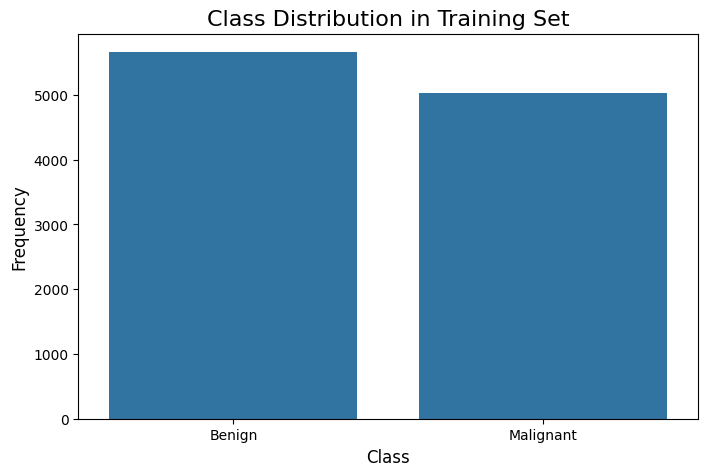

In [ ]:
#class distribution in training set
train_class_counts = [sum(train_generator.classes == i) for i in range(2)]
plt.figure(figsize=(8, 5))
sns.barplot(x=['Benign', 'Malignant'], y=train_class_counts)
plt.xlabel('Class', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Class Distribution in Training Set', size=16)
plt.show()

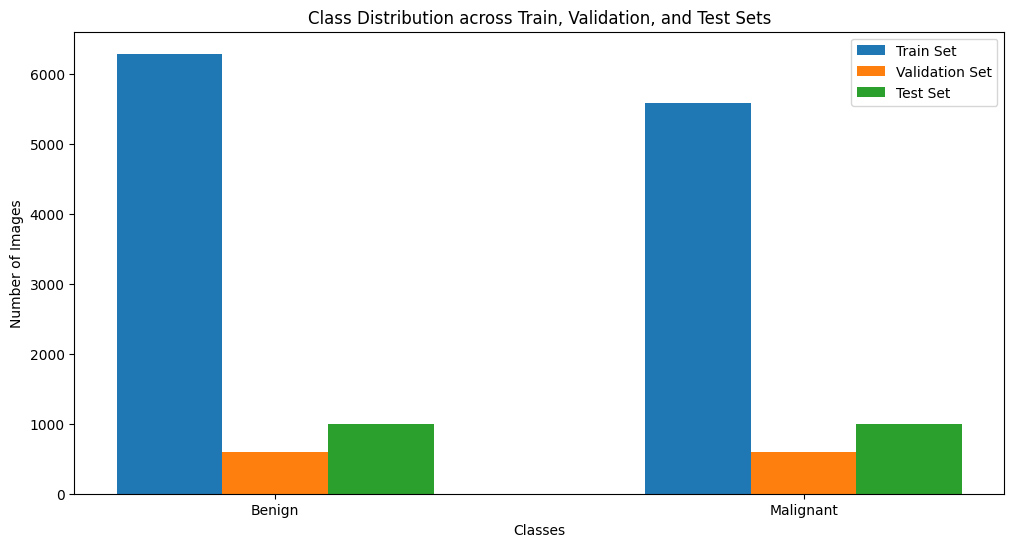

In [ ]:
# Another Class distribution
train_class_counts = [train_benign_count, train_malignant_count]
validation_class_counts = [len(validation_generator.filenames) // 2, len(validation_generator.filenames) // 2]
test_class_counts = [len(test_generator.filenames) // 2, len(test_generator.filenames) // 2]

labels = ['Benign', 'Malignant']
x = range(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, train_class_counts, width=0.2, label='Train Set', align='center')
plt.bar([p + 0.2 for p in x], validation_class_counts, width=0.2, label='Validation Set', align='center')
plt.bar([p + 0.4 for p in x], test_class_counts, width=0.2, label='Test Set', align='center')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()
plt.title('Class Distribution across Train, Validation, and Test Sets')
plt.show()

In [ ]:
# Model setup with VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

# Custom layers on top of VGG19
x = base_model.output
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=output)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])


"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('melanoma_classifierVGG.keras', save_best_only=True)
]
"""


"\ncallbacks = [\n    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),\n    ModelCheckpoint('melanoma_classifierVGG.keras', save_best_only=True)\n]\n"

In [13]:
epochs = 15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


335/335 ━━━━━━━━━━━━━━━━━━━━ 275s 696ms/step - accuracy: 0.6929 - loss: 0.5813 - recall: 0.6306 - val_accuracy: 0.6318 - val_loss: 0.7278 - val_recall: 0.2737
Epoch 2/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 210s 619ms/step - accuracy: 0.8417 - loss: 0.3847 - recall: 0.8049 - val_accuracy: 0.7515 - val_loss: 0.4926 - val_recall: 0.7513
Epoch 3/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 262s 618ms/step - accuracy: 0.8619 - loss: 0.3305 - recall: 0.8271 - val_accuracy: 0.7826 - val_loss: 0.4543 - val_recall: 0.8122
Epoch 4/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 216s 637ms/step - accuracy: 0.8647 - loss: 0.3212 - recall: 0.8409 - val_accuracy: 0.7700 - val_loss: 0.4913 - val_recall: 0.7084
Epoch 5/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 257s 619ms/step - accuracy: 0.8728 - loss: 0.3103 - recall: 0.8465 - val_accuracy: 0.7414 - val_loss: 0.5558 - val_recall: 0.6136
Epoch 6/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 260s 617ms/step - accuracy: 0.8802 - loss: 0.2960 - recall: 0.8620 - val_accuracy: 0.7388 - val_loss: 0.4707 - val_recall

In [14]:
# Evaluation on test data
loss, accuracy, recall = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy}')
print(f'Test Recall: {recall}')
print(f'Test Loss: {loss}')


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.9252 - loss: 0.2018 - recall: 0.4446
Test Accuracy: 0.8849999904632568
Test Recall: 0.8299999833106995
Test Loss: 0.27595484256744385


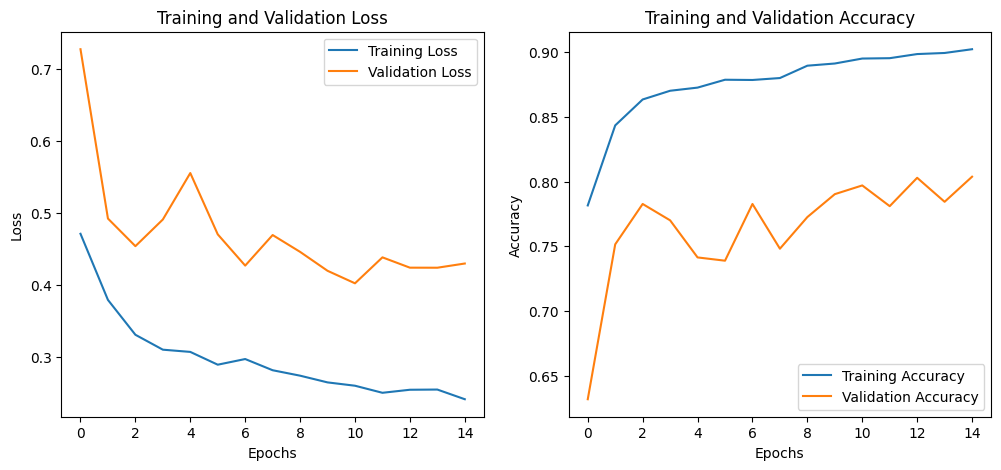

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step


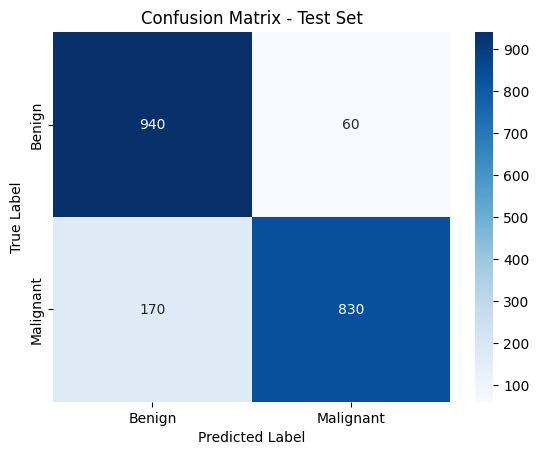

Classification Report:
               precision    recall  f1-score   support

      Benign       0.85      0.94      0.89      1000
   Malignant       0.93      0.83      0.88      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.88      2000
weighted avg       0.89      0.89      0.88      2000



In [15]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
from sklearn.metrics import confusion_matrix, classification_report

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Confusion matrix on test data
test_labels = test_generator.classes
test_preds = (model.predict(test_generator) > 0.5).astype("int32")

conf_matrix = confusion_matrix(test_labels, test_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step


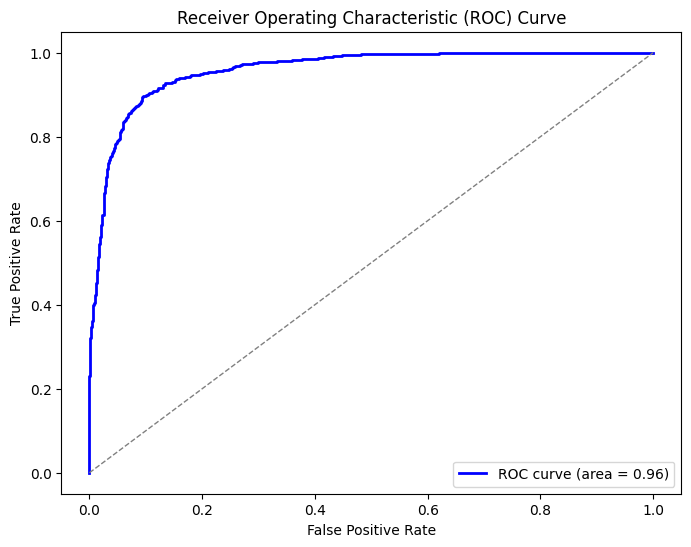

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_pred_prob = model.predict(test_generator).ravel()  
y_true = test_generator.classes

# ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)  
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')  # Diagonale lijn
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [18]:
#saving the model (the '25' stands for run #25, for my information)
model.save('VGG25trained_model.h5') 


In [19]:
#download model
from google.colab import files
files.download('VGG25trained_model.h5')  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#

#
EfficientNetB0 model on the filtered HAM10000 dataset

In [20]:
#import libraries again (if needed)
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Recall
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG19
from tensorflow.keras.metrics import Recall
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import json


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #no warnings

In [ ]:
#uploading the trained EfficientNetB0 model (if needed)

#from google.colab import files
#uploaded = files.upload()


In [17]:
#mount drive 
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# if needed, upload the filtered dataset,if you don't want to use google drive

"""
from google.colab import files
uploaded = files.upload()  # Select dataset.zip file
"""

In [ ]:
"""

os.makedirs('data', exist_ok=True)

with zipfile.ZipFile('HAM10000_balanced_nv_mel_equal_gender.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
"""

In [ ]:
#test_dir = '/content/data/HAM10000_balanced_nv_mel_equal_gender'
#metadata_file = '/content/data/HAM10000_balanced_nv_mel_equal_gender/HAM10000_filtered_metadata.csv'


In [21]:
model_path = '/content/VGG25trained_model.h5'
model = tf.keras.models.load_model(model_path)
print("Model geladen van:", model_path)

Model geladen van: /content/VGG25trained_model.h5


In [22]:
test_dir = '/content/drive/My Drive/kaggle/HAM10000_balanced_nv_mel_equal_gender'
metadata_file = '/content/drive/My Drive/kaggle/HAM10000_balanced_nv_mel_equal_gender/HAM10000_filtered_metadata.csv'


In [23]:
# check files
import os
print(os.path.exists(test_dir))
print(os.path.exists(metadata_file))

# Load metadata
import pandas as pd
metadata = pd.read_csv(metadata_file)
print(metadata.head())

True
True
     lesion_id      image_id  dx    dx_type   age     sex localization
0  HAM_0002056  ISIC_0026762  nv  follow_up  55.0  female        trunk
1  HAM_0004149  ISIC_0032755  nv      histo  45.0  female         foot
2  HAM_0002663  ISIC_0030720  nv  follow_up  35.0  female        trunk
3  HAM_0001502  ISIC_0027482  nv  follow_up  55.0  female      abdomen
4  HAM_0005017  ISIC_0027461  nv      histo  75.0  female         back


In [24]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1696 images belonging to 2 classes.


In [41]:
steps = test_generator.samples // test_generator.batch_size

In [42]:
#evaluation on this filtered dataset
loss, accuracy, recall = model.evaluate(test_generator, steps=steps)
print("Evaluation Results:", results)

53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.8214 - loss: 0.4751 - recall: 0.4387
Evaluation Results: [0.4493658244609833, 0.8278301954269409, 0.8962264060974121]


In [43]:
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test Recall: {results[2]}")


Test Loss: 0.4493658244609833
Test Accuracy: 0.8278301954269409
Test Recall: 0.8962264060974121


In [58]:
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, steps=steps).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step


In [59]:
# check balance in metadata
print("Metadata class distribution:\n", metadata['true_labels'].value_counts())
print("Metadata gender distribution:\n", metadata['sex'].value_counts())

# check balance in test gen (y_true)
print("Test generator class distribution:\n", pd.Series(y_true).value_counts())


Metadata class distribution:
 true_labels
0    848
1    848
Name: count, dtype: int64
Metadata gender distribution:
 sex
female    848
male      848
Name: count, dtype: int64
Test generator class distribution:
 0    848
1    848
Name: count, dtype: int64


In [61]:
# Confusionmatrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification rapport
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

Confusion Matrix:
 [[644 204]
 [ 88 760]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.88      0.76      0.82       848
   Malignant       0.79      0.90      0.84       848

    accuracy                           0.83      1696
   macro avg       0.83      0.83      0.83      1696
weighted avg       0.83      0.83      0.83      1696



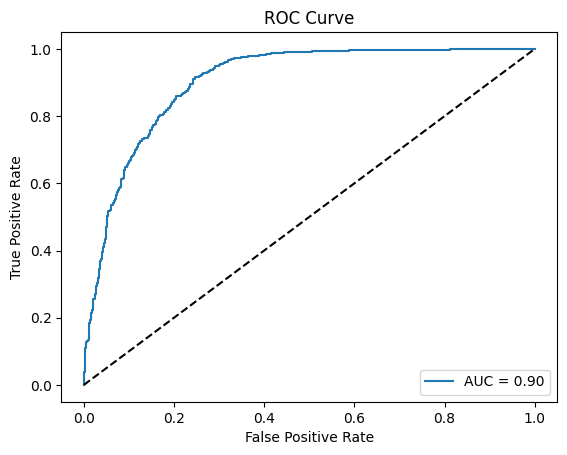

AUC-ROC: 0.90


In [49]:
# AUC-ROC curve
roc_auc = roc_auc_score(y_true, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
print(f"AUC-ROC: {roc_auc:.2f}")

In [50]:
# Gender (male and female) performance
# Load metadata
metadata = pd.read_csv(metadata_file)
metadata['true_labels'] = metadata['dx'].map({'nv': 0, 'mel': 1})  
metadata['predictions'] = y_pred  

# performance for gender
results_by_gender = {}
for gender in ['male', 'female']:
    gender_data = metadata[metadata['sex'] == gender]
    true_labels = gender_data['true_labels']
    predictions = gender_data['predictions']

    # Confusionmatrix and classification rapport
    conf_matrix = confusion_matrix(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=['Benign', 'Malignant'], output_dict=True)

    results_by_gender[gender] = {
        'confusion_matrix': conf_matrix,
        'classification_report': report
    }
    print(f"\nPerformance for {gender.capitalize()} Patients:")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_report(true_labels, predictions, target_names=['Benign', 'Malignant']))


Performance for Male Patients:
Confusion Matrix:
 [[278 146]
 [ 16 408]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.95      0.66      0.77       424
   Malignant       0.74      0.96      0.83       424

    accuracy                           0.81       848
   macro avg       0.84      0.81      0.80       848
weighted avg       0.84      0.81      0.80       848


Performance for Female Patients:
Confusion Matrix:
 [[366  58]
 [ 72 352]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.84      0.86      0.85       424
   Malignant       0.86      0.83      0.84       424

    accuracy                           0.85       848
   macro avg       0.85      0.85      0.85       848
weighted avg       0.85      0.85      0.85       848



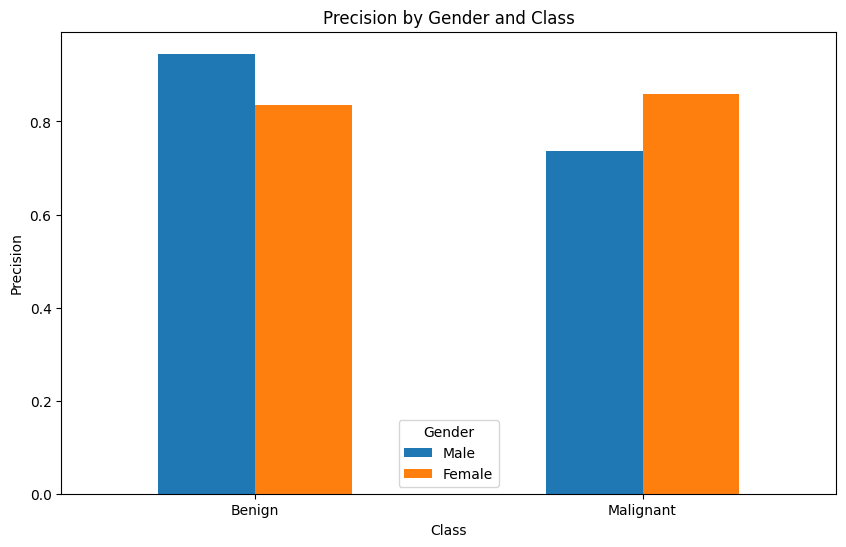

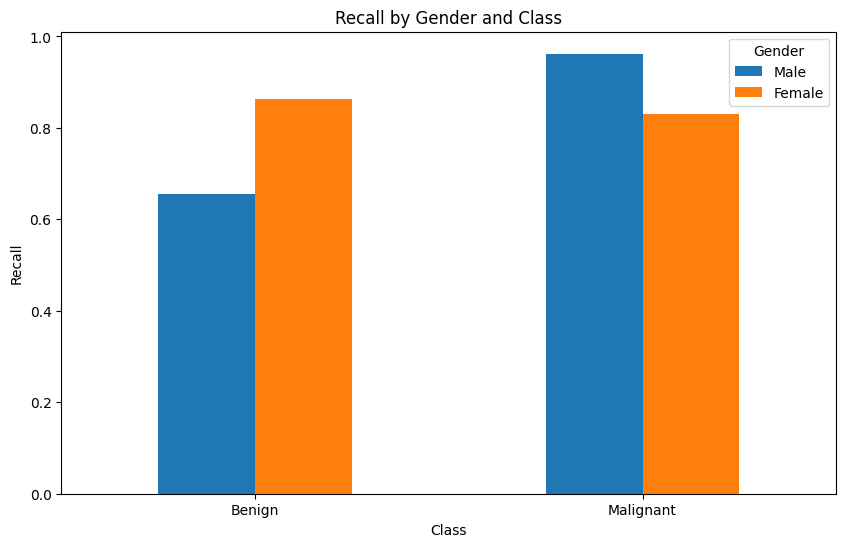

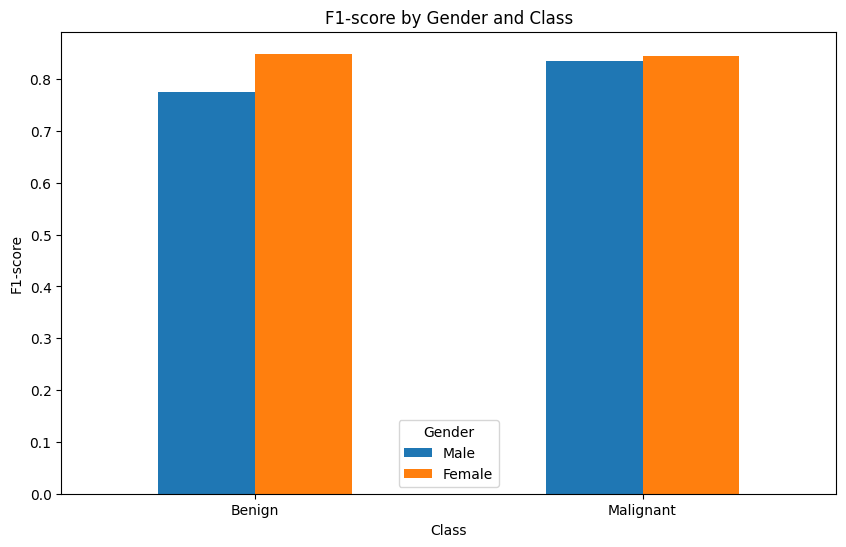

In [51]:
# Plots for quick overview
metrics = ['precision', 'recall', 'f1-score']
classes = ['Benign', 'Malignant']
gender_metrics = {metric: {gender: [] for gender in ['male', 'female']} for metric in metrics}

for gender in results_by_gender:
    for metric in metrics:
        for cls in classes:
            gender_metrics[metric][gender].append(results_by_gender[gender]['classification_report'][cls][metric])

# Plot per metric
for metric in metrics:
    data = pd.DataFrame(gender_metrics[metric], index=classes)
    data.plot(kind='bar', figsize=(10, 6))
    plt.title(f"{metric.capitalize()} by Gender and Class")
    plt.ylabel(metric.capitalize())
    plt.xlabel("Class")
    plt.xticks(rotation=0)
    plt.legend(title="Gender", labels=['Male', 'Female'])
    plt.show()

In [52]:
for gender in ['male', 'female']:
    gender_data = metadata[metadata['sex'] == gender]
    true_labels = gender_data['true_labels'].values
    predictions = gender_data['predictions'].values
    probabilities = y_pred_proba[gender_data.index]  

    # AUC-ROC
    auc_score = roc_auc_score(true_labels, probabilities)
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
    print(f"AUC for {gender.capitalize()} Patients: {auc_score:.2f}")

AUC for Male Patients: 0.91
AUC for Female Patients: 0.92



Confusion Matrix for Male Patients:
[[278 146]
 [ 16 408]]
AUC for Male Patients: 0.91


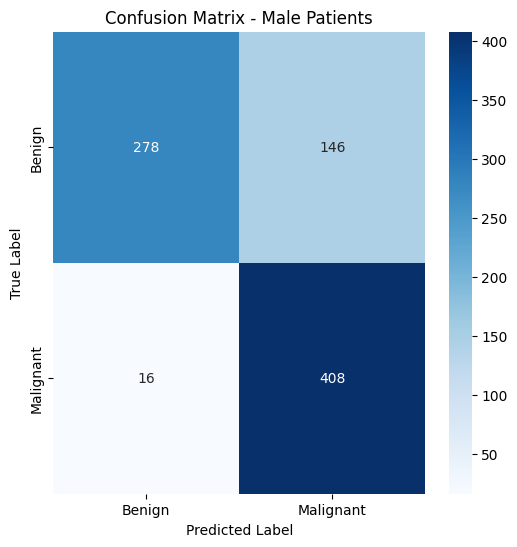

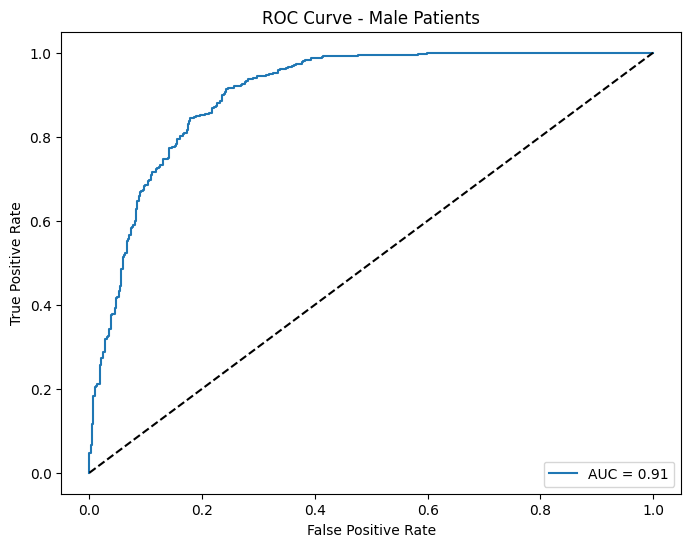


Confusion Matrix for Female Patients:
[[366  58]
 [ 72 352]]
AUC for Female Patients: 0.92


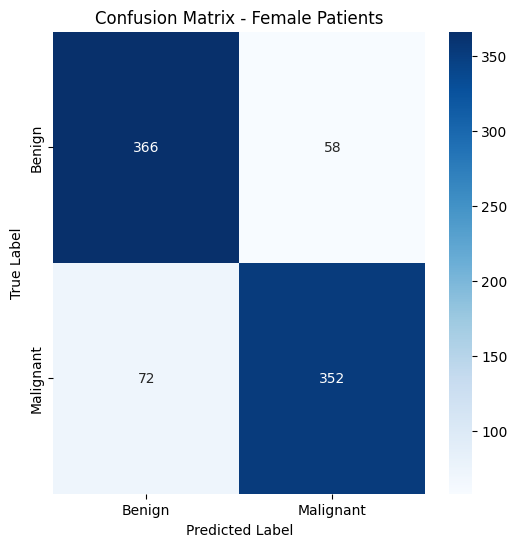

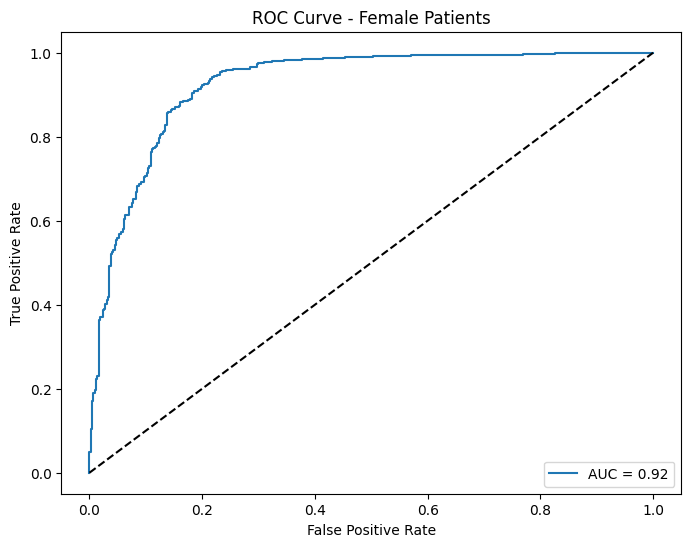

In [53]:
# Gender performance with small and big confusion matrix and AUC-ROC score
for gender in ['male', 'female']:
    gender_data = metadata[metadata['sex'] == gender]
    true_labels = gender_data['true_labels'].values
    predictions = gender_data['predictions'].values
    probabilities = y_pred_proba[gender_data.index]  

    # Confusion Matrix
    conf_matrix_gender = confusion_matrix(true_labels, predictions)
    print(f"\nConfusion Matrix for {gender.capitalize()} Patients:")
    print(conf_matrix_gender)

    # AUC-ROC
    auc_score = roc_auc_score(true_labels, probabilities)
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
    print(f"AUC for {gender.capitalize()} Patients: {auc_score:.2f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix_gender, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix - {gender.capitalize()} Patients")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.title(f"ROC Curve - {gender.capitalize()} Patients")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()